In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.cloud import storage


2025-05-31 14:31:55.098782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 14:31:55.098828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 14:31:55.100754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 14:31:55.115553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

BUCKET_NAME = "bucket-signlink"
ZIP_BLOB_NAME = "libras_reprocessado.zip"


LOCAL_ZIP_PATH = "libras_reprocessado.zip"
EXTRACT_DIR   = "/home/jpviguini/testes/tmp"

def download_and_extract_zip_from_gcs(bucket_name: str,
                                     blob_name: str,
                                     download_path: str,
                                     extract_to: str):
    
 
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    print(f"Baixando {blob_name} do bucket {bucket_name} para {download_path}...")
    blob.download_to_filename(download_path)
    print("Download concluído.")

  
    os.makedirs(extract_to, exist_ok=True)

   
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        print(f"Extraindo arquivos para {extract_to}...")
        zip_ref.extractall(extract_to)
    print("Extração concluída.")


download_and_extract_zip_from_gcs(
    BUCKET_NAME,
    ZIP_BLOB_NAME,
    LOCAL_ZIP_PATH,
    EXTRACT_DIR
)

Baixando libras_reprocessado.zip do bucket bucket-signlink para libras_reprocessado.zip...


Download concluído.
Extraindo arquivos para /home/jpviguini/testes/tmp...
Extração concluída.


In [20]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
list_path = []
list_labels = []


DATA_PATHS = [
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-viguini-esquerda", 
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-viguini-direita", 
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-iamato-esquerda", 
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-iamato-direita", 
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-dani-esquerda",
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-dani-direita", 
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-odonto-esquerda", 
                "./tmp/libras_reprocessado/libras_aug_com_landmarks_novo/libras_augmentadas_heavy/libras-odonto-direita", 

                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-viguini-esquerda", 
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-viguini-direita", 
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-iamato-esquerda", 
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-iamato-direita", 
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-dani-esquerda",
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-dani-direita", 
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-odonto-esquerda", 
                "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-odonto-direita", 


                ] 

TEST_PATHS = ["./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-cecilia-direita", 
              "./tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-cecilia-esquerda"]

for path in DATA_PATHS:
    if path not in TEST_PATHS:
        for label in labels:
            label_path = os.path.join(path, label, "*")
            
            image_files = glob.glob(label_path)
            
            sign_label = [label] * len(image_files)
            
            list_path.extend(image_files)
            list_labels.extend(sign_label)

data_train = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

list_path = []
list_labels = []

for test_path in TEST_PATHS:
    for label in labels:
        label_path = os.path.join(test_path, label, "*")
        image_files = glob.glob(label_path)
        
        sign_label = [label] * len(image_files)
        
        list_path.extend(image_files)
        list_labels.extend(sign_label)

data_val = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})



In [ ]:
# corrigir os labels do odonto (botar pra maiúscula)
pasta_principal = "/home/jpviguini/testes/tmp/libras_reprocessado/libras_normal_com_landmarks_novo/libras-odonto-esquerda"


for item in os.listdir(pasta_principal):
    caminho_antigo = os.path.join(pasta_principal, item)

    if os.path.isdir(caminho_antigo):
        nome_maiusculo = item.upper()
        caminho_novo = os.path.join(pasta_principal, nome_maiusculo)

        if caminho_antigo != caminho_novo:
            if not os.path.exists(caminho_novo):
                os.rename(caminho_antigo, caminho_novo)
                print(f"Renomeado: {item} -> {nome_maiusculo}")
            else:
                print(f"Já existe uma pasta com o nome: {nome_maiusculo} — ignorando.")

Renomeado: f -> F
Renomeado: p -> P
Renomeado: v -> V
Renomeado: s -> S
Renomeado: o -> O
Renomeado: e -> E
Renomeado: g -> G
Renomeado: d -> D
Renomeado: q -> Q
Renomeado: t -> T
Renomeado: b -> B
Renomeado: m -> M
Renomeado: a -> A
Renomeado: c -> C
Renomeado: w -> W
Renomeado: r -> R
Renomeado: n -> N
Renomeado: u -> U
Renomeado: l -> L
Renomeado: y -> Y
Renomeado: i -> I


In [ ]:


min_count = data_train['label'].value_counts().min()


balanced_train = pd.DataFrame()

# Para cada label, pegar min_count amostras
for label in data_train['label'].unique():
    label_df = data_train[data_train['label'] == label]
    if len(label_df) > min_count:
        label_df = label_df.sample(min_count, random_state=42)  # random_state para reprodutibilidade
    balanced_train = pd.concat([balanced_train, label_df])

# Embaralhar os dados
balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)


data_train = balanced_train

# Verificar o resultado
print("Distribuição das classes no treino balanceado:")
print(data_train['label'].value_counts())


list_path = []
list_labels = []

for test_path in TEST_PATHS:
    for label in labels:
        label_path = os.path.join(test_path, label, "*")
        image_files = glob.glob(label_path)
        sign_label = [label] * len(image_files)
        list_path.extend(image_files)
        list_labels.extend(sign_label)

data_val = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

# data_train['label'].value_counts()

Distribuição das classes no treino balanceado:
label
W    3706
L    3706
G    3706
C    3706
F    3706
A    3706
S    3706
B    3706
E    3706
N    3706
V    3706
D    3706
O    3706
I    3706
P    3706
T    3706
R    3706
M    3706
Q    3706
Y    3706
U    3706
Name: count, dtype: int64


In [7]:
label_to_index = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'I': 7,
    'L': 8,
    'M': 9,
    'N': 10,
    'O': 11,
    'P': 12,
    'Q': 13,
    'R': 14,
    'S': 15,
    'T': 16,
    'U': 17,
    'V': 18,
    'W': 19,
    'Y': 20
}


data_train['label'] = data_train['label'].map(label_to_index)
data_val['label'] = data_val['label'].map(label_to_index)

In [8]:
data_val.head(10)

,image_path,label
0,./tmp/libras_reprocessado/libras_normal_com_la...,0
1,./tmp/libras_reprocessado/libras_normal_com_la...,0
2,./tmp/libras_reprocessado/libras_normal_com_la...,0
3,./tmp/libras_reprocessado/libras_normal_com_la...,0
4,./tmp/libras_reprocessado/libras_normal_com_la...,0
5,./tmp/libras_reprocessado/libras_normal_com_la...,0
6,./tmp/libras_reprocessado/libras_normal_com_la...,0
7,./tmp/libras_reprocessado/libras_normal_com_la...,0
8,./tmp/libras_reprocessado/libras_normal_com_la...,0
9,./tmp/libras_reprocessado/libras_normal_com_la...,0


In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train['image_path'].values, data_train['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((data_val['image_path'].values, data_val['label'].values))

2025-05-31 14:36:39.104669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-31 14:36:39.125962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-31 14:36:39.127941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMG_SIZE = (224, 224)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

In [11]:
BATCH_SIZE = 32
train_ds = train_ds.map(process_image)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.map(process_image)
val_ds = val_ds.batch(BATCH_SIZE)

In [12]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [13]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

num_classes = data_train['label'].nunique()

base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
EPOCHS = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/8


2025-05-31 14:36:56.799776: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-05-31 14:36:58.837107: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3a1c76e700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-31 14:36:58.837152: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-05-31 14:36:58.845303: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748702218.964721 1867880 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2433/2433 [==============================] - 114s 45ms/step - loss: 1.8292 - accuracy: 0.9127 - val_loss: 14.6893 - val_accuracy: 0.6138
Epoch 2/8
2433/2433 [==============================] - 109s 45ms/step - loss: 0.8624 - accuracy: 0.9695 - val_loss: 16.8404 - val_accuracy: 0.6466
Epoch 3/8
2433/2433 [==============================] - 109s 45ms/step - loss: 0.6399 - accuracy: 0.9794 - val_loss: 19.0966 - val_accuracy: 0.6721
Epoch 4/8
2433/2433 [==============================] - 109s 45ms/step - loss: 0.5183 - accuracy: 0.9846 - val_loss: 24.1659 - val_accuracy: 0.6538
Epoch 5/8
2433/2433 [==============================] - 108s 44ms/step - loss: 0.4557 - accuracy: 0.9875 - val_loss: 30.0806 - val_accuracy: 0.6340
Epoch 6/8
2433/2433 [==============================] - 109s 45ms/step - loss: 0.3529 - accuracy: 0.9903 - val_loss: 44.7270 - val_accuracy: 0.6076
Epoch 7/8
2433/2433 [==============================] - 109s 45ms/step - loss: 0.3313 - accuracy: 0.9916 - val_loss: 33.9031 - va

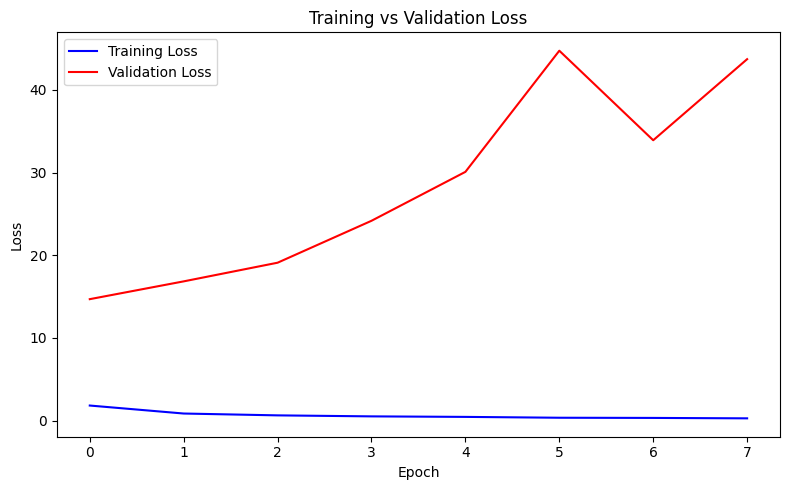

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(EPOCHS)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

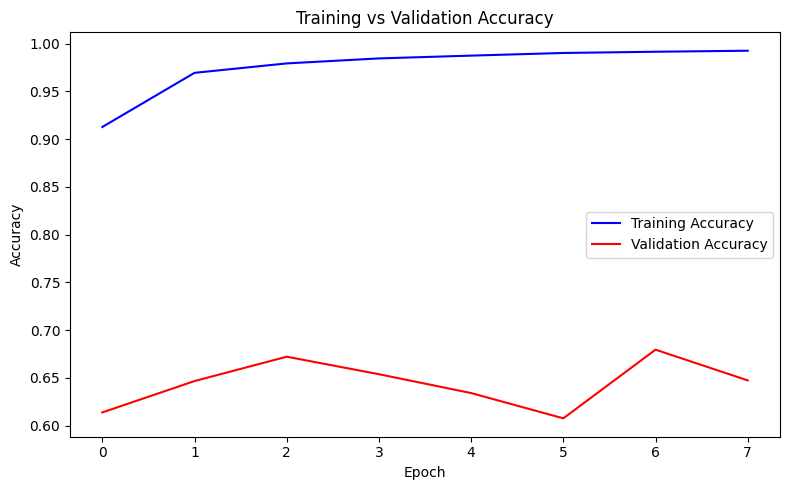

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

# === Parameters ===
image_size = (224, 224)  # MobileNet expects 224x224
batch_size = 32
test_dir = TEST_PATHS[0]

# === Data Generator ===
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === Predict ===
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# === Confusion Matrix & Accuracy ===
cm = confusion_matrix(true_classes, predicted_classes)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
total_accuracy = accuracy_score(true_classes, predicted_classes)

# === Print Results ===
df_accuracy = pd.DataFrame({
    'Class': class_labels,
    'Accuracy': per_class_accuracy
})

print("Per-class Accuracy:\n")
print(df_accuracy)
print(f"\nTotal Accuracy: {total_accuracy:.4f}")


Found 8967 images belonging to 21 classes.
281/281 [==============================] - 15s 51ms/step
Per-class Accuracy:

   Class  Accuracy
0      A  0.615804
1      B  0.856132
2      C  0.977215
3      D  0.790754
4      E  0.902564
5      F  0.941889
6      G  0.289855
7      I  0.849383
8      L  0.879808
9      M  0.515400
10     N  0.447619
11     O  0.895735
12     P  0.986456
13     Q  0.712264
14     R  0.985112
15     S  0.823276
16     T  0.015414
17     U  0.243750
18     V  0.016471
19     W  1.000000
20     Y  0.637232

Total Accuracy: 0.6726


In [22]:
model.save('models/mobilenet_padronizado.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model.save("libras_heavy_balanceado_ceci.keras", save_format="keras_v3")